Significance:

$$Z = \frac{S}{\sqrt{S+B}}$$

In [1]:
import awkward as ak
import pandas as pd
import numpy as np
import vector
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents import NanoAODSchema, DelphesSchema
import mplhep as hep
import matplotlib.pyplot as plt
import seaborn as sns
import DM_HEP_AN as dm
from math import pi
from funcs import *
hep.style.use("CMS")
#%matplotlib inline
plt.ioff()

In [2]:
# Signal
cases = ["gSq_only","gSg1_only", "gSg2_only_y0y0", "gSg_only"]
data = {}
for i in cases:
    csvFile = [f"./sim_outputs/csv/DM_{i}_1.csv", f"./sim_outputs/csv/DM_{i}_2.csv"]
    data[i] = [pd.read_csv(j) for j in csvFile]

In [3]:
print("Número de Eventos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])

Número de Eventos:  [[50000, 50000], [50000, 50000], [50000, 50000], [50000, 50000]]


In [4]:
# Background
csvFile = "./background/ZpJets.csv"
data_ZpJ = pd.read_csv(csvFile)
csvFile = "./background/WpJets.csv"
data_WpJ = pd.read_csv(csvFile)

Cross-section

In [5]:
CSs = {}
for i in cases:
    CSs[f"{i}"] = []
    CSs[f"error{i}"] = []

In [6]:
outFile = "sim_outputs/log.out"
outData = open(outFile, "r")
outText = outData.read()
outData.close()

In [7]:
indexCS = outText.find('Cross-section :   ')
indexPM = outText.find(' +- ', indexCS)
indexPB = outText.find(' pb', indexCS)
counter = 0
repCount = True
run = 1
while indexCS != -1:
    if repCount:
        repCount = False
    else:
        #print("Cross-section: ", outText[indexCS+18:indexPM])
        #print("errorbar :", outText[indexPM+4:indexPB])
        CSs[f"{cases[counter]}"].append(float(outText[indexCS+18:indexPM]))
        CSs[f"error{cases[counter]}"].append(float(outText[indexPM+4:indexPB]))
        match run:
            case 1:
                run = 2
            case 2:
                run = 1
                counter +=1
        repCount = True
    indexCS = outText.find('Cross-section :   ', indexCS+1)
    indexPM = outText.find(' +- ', indexCS)
    indexPB = outText.find(' pb', indexCS)
print(counter)

4


In [8]:
CSs

{'gSq_only': [0.0008833, 3.692e-05],
 'errorgSq_only': [1.722e-06, 7.012e-08],
 'gSg1_only': [41.16, 6.965],
 'errorgSg1_only': [0.06192, 0.01127],
 'gSg2_only_y0y0': [0.002104, 0.0001629],
 'errorgSg2_only_y0y0': [3.224e-06, 2.454e-07],
 'gSg_only': [41.2, 6.972],
 'errorgSg_only': [0.06122, 0.01005]}

In [9]:
# fictious cross section
newCS = 0.1 # pb (100 fb)
CSs['gSq_only'] = [newCS, newCS]
CSs['gSg2_only_y0y0'] = [newCS, newCS]

Construct variables

In [10]:
funcVariables = [invariant_mass, azimuthal_difference, pseudorapidity_separation, pseudorapidity_product]
variables = ["Inv_Mass", "Azim_diff", "Pseudorapidity", "PseudorapidityProd"]
           
for i in range(len(variables)):
    data_WpJ[variables[i]] = data_WpJ.apply(funcVariables[i], axis=1)
    data_ZpJ[variables[i]] = data_ZpJ.apply(funcVariables[i], axis=1)
    for j in cases:
        for k in range(2):
            data[j][k][variables[i]] = data[j][k].apply(funcVariables[i], axis=1)

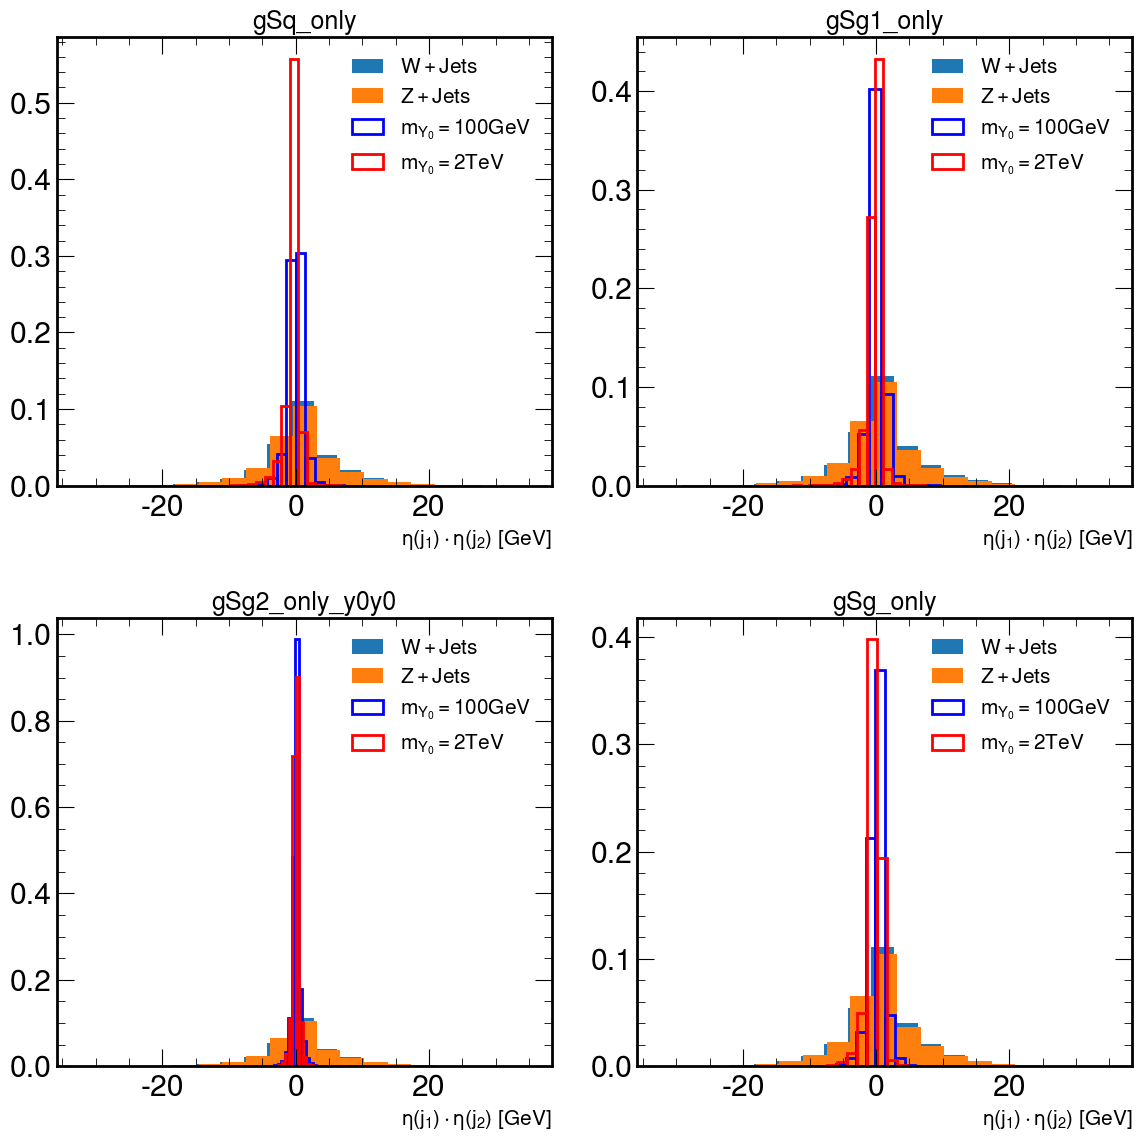

In [11]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'PseudorapidityProd'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$ [GeV]",fontsize=15)


fig.tight_layout()
plt.show()


# Significance

Weights

$$W = \frac{N_{fisicos}}{N_{MG+Pythia}}$$

In [12]:
Weights = pd.read_csv("BGweigths.csv").to_dict()
# Luminosity to normalize
lum = 1 # fb-1

for i in cases:
    Weights[i] = []
    for j in range(2):
        Weights[i].append(CSs[i][j]*1000*lum/data[i][j].shape[0])

In [13]:
Weights['WpJets'] = Weights['WpJets'][0]
Weights['ZpJets'] = Weights['ZpJets'][0]
Weights.pop('Unnamed: 0')

{0: 0}

In [14]:
Weights

{'WpJets': 19.35116374450751,
 'ZpJets': 5.5599459000968485,
 'gSq_only': [0.002, 0.002],
 'gSg1_only': [0.8232, 0.1393],
 'gSg2_only_y0y0': [0.002, 0.002],
 'gSg_only': [0.824, 0.13944]}

### Cut in $p_{T}(j_{0})$

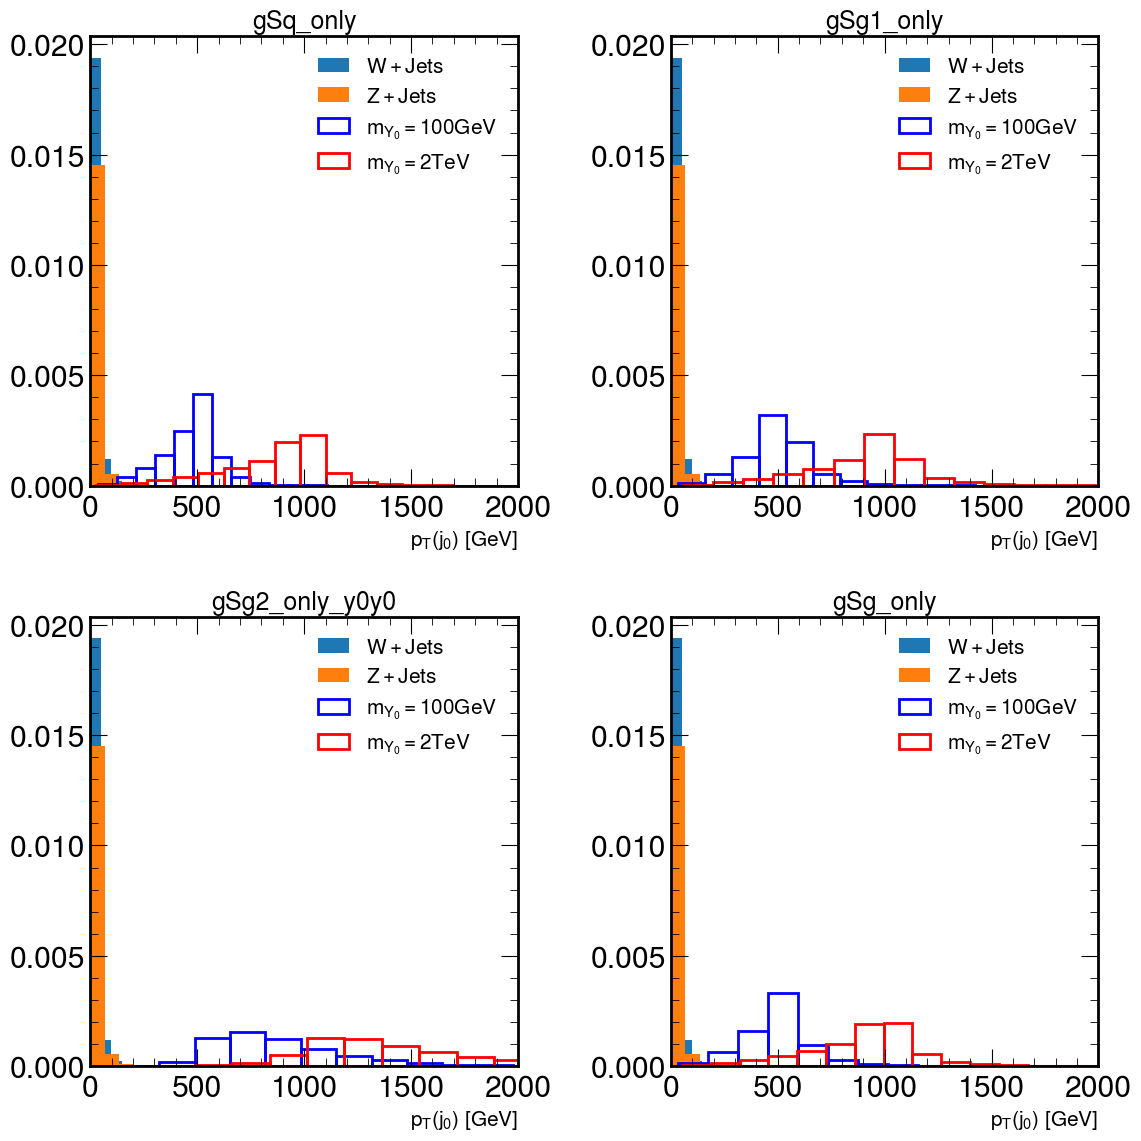

In [16]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'jet_pt0'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$p_{T}{(j_{0})}$ [GeV]",fontsize=15)
        ax[i,j].set_xlim(0,2000)


fig.tight_layout()
plt.show()


In [17]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt0', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/workspaces/VBFDM_EAFIT/funcs.py:326: RuntimeWarning: invalid value encountered in scalar divide
  Z[i][j][k] = S / np.sqrt(S + B)


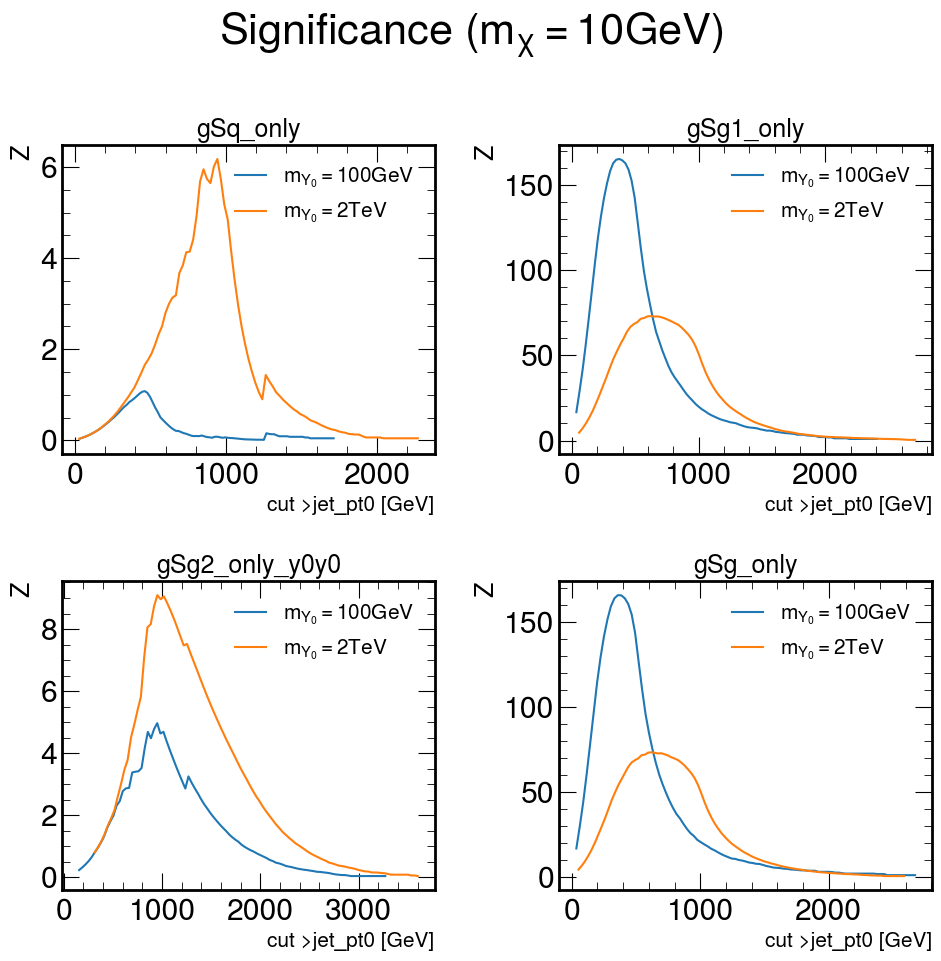

In [18]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

Acotamos el rango de busqueda

In [19]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt0', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']],
                                 set_lims=True, lims=(0,1500), size=500)

In [20]:
cuts = get_cuts(cases, Z, pt_values, "jet_pt0", "GeV", ["my0=100GeV", "my0=2TeV"], printResults=True)

case : gSq_only
	mass point: my0=100GeV
		max significance: 1.080159935232787
		cut: jet_pt0 > 464.101GeV
	mass point: my0=2TeV
		max significance: 6.2294267252037905
		cut: jet_pt0 > 939.476GeV
case : gSg1_only
	mass point: my0=100GeV
		max significance: 165.6605433550792
		cut: jet_pt0 > 361.721GeV
	mass point: my0=2TeV
		max significance: 73.17980097163112
		cut: jet_pt0 > 621.052GeV
case : gSg2_only_y0y0
	mass point: my0=100GeV
		max significance: 5.07798979442718
		cut: jet_pt0 > 940.208GeV
	mass point: my0=2TeV
		max significance: 9.189593061962707
		cut: jet_pt0 > 992.03GeV
case : gSg_only
	mass point: my0=100GeV
		max significance: 165.73287410691918
		cut: jet_pt0 > 361.629GeV
	mass point: my0=2TeV
		max significance: 73.16483304950161
		cut: jet_pt0 > 620.927GeV


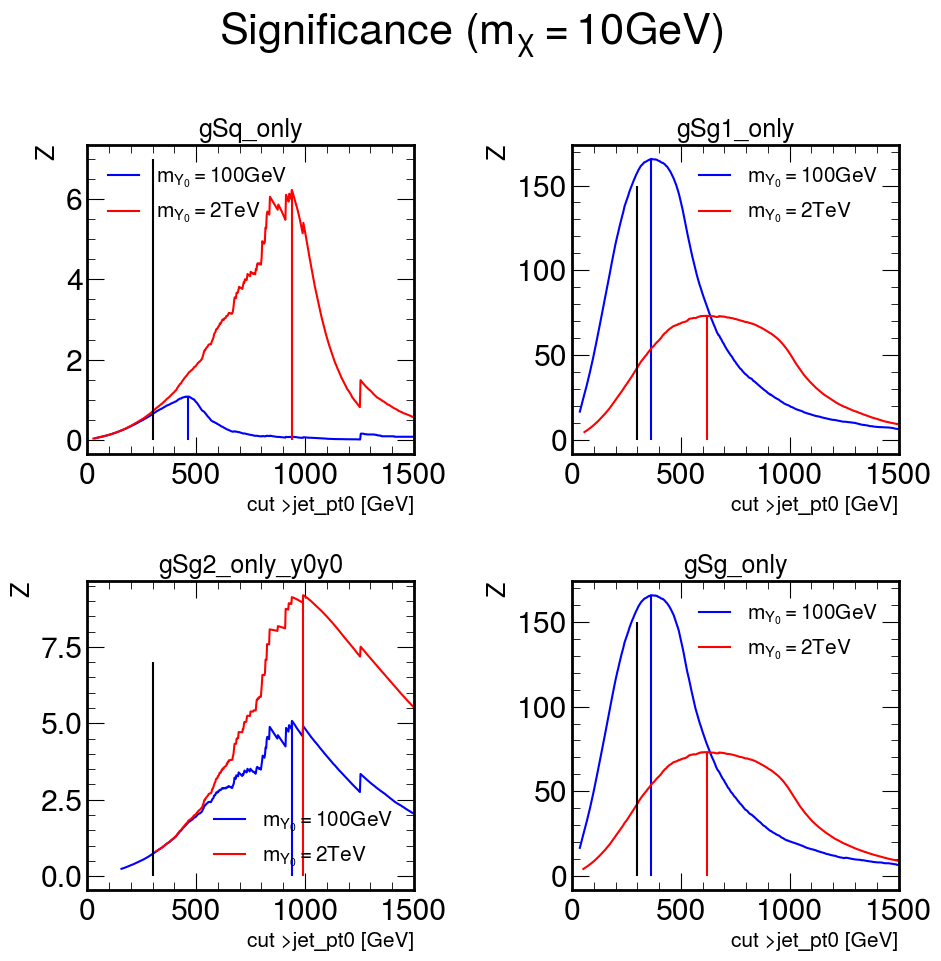

In [21]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

colors = ["b","r"]
labels = [r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"]

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i],color=colors[i], label=labels[i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i],color=colors[i], label=labels[i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i],color=colors[i], label=labels[i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i],color=colors[i], label=labels[i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=max(Z[cases[0]][i]),color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=max(Z[cases[1]][i]),color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=max(Z[cases[2]][i]),color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=max(Z[cases[3]][i]),color=colors[i])

ax[0,0].vlines(300, ymin=0, ymax=7, color='black')
ax[0,1].vlines(300, ymin=0, ymax=150, color='black')
ax[1,0].vlines(300, ymin=0, ymax=7, color='black')
ax[1,1].vlines(300, ymin=0, ymax=150, color='black')

for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1500)

fig.tight_layout()
plt.show()

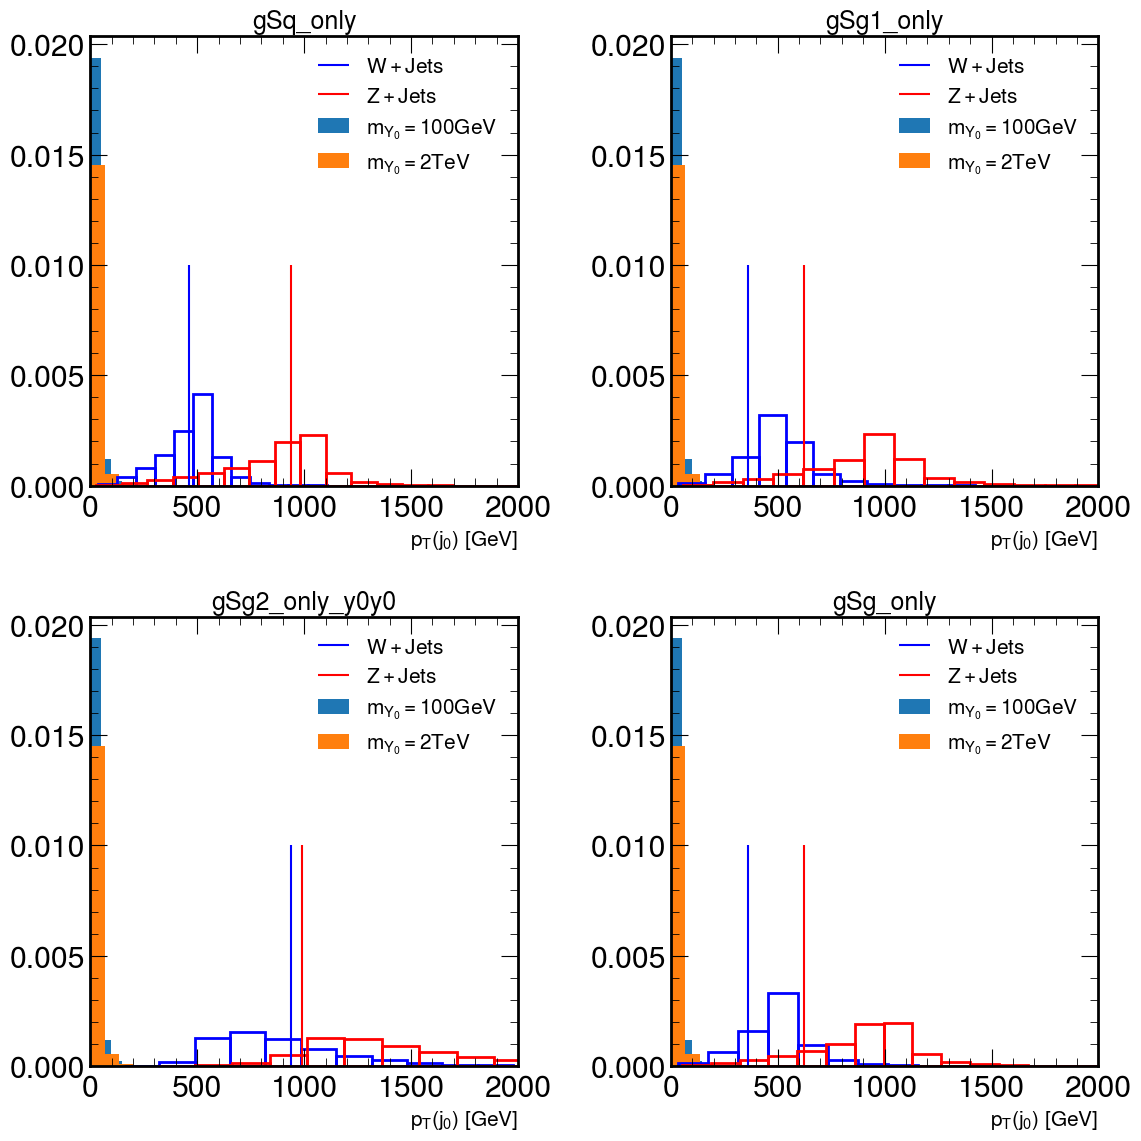

In [22]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'jet_pt0'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=0.01,color=colors[i])

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$p_{T}{(j_{0})}$ [GeV]",fontsize=15)
        ax[i,j].set_xlim(0,2000)


fig.tight_layout()
plt.show()


Cut in 200GeV

In [23]:
cut_data = {}
dataWpJ_cut = {}
dataZpJ_cut = {}
for i in cases:
    cut_data[i] = []
    dataWpJ_cut[i] = []
    dataZpJ_cut[i] = []
    for j in range(2):
        #cut_data[i].append(data[i][j][data[i][j]['jet_pt0'] > cuts[i][j]].copy())
        #dataWpJ_cut[i].append(data_WpJ[data_WpJ['jet_pt0'] > cuts[i][j]].copy())
        #dataZpJ_cut[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > cuts[i][j]].copy())
        cut_data[i].append(data[i][j][data[i][j]['jet_pt0'] > 200].copy()) # jet_pt0 > 300GeV
        dataWpJ_cut[i].append(data_WpJ[data_WpJ['jet_pt0'] > 200].copy()) # jet_pt0 > 300GeV
        dataZpJ_cut[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > 200].copy()) # jet_pt0 > 300GeV

In [24]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])
print("\tCut")
print("Modelos: ",[[cut_data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets: ",[[dataWpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("ZpJets: ",[[dataZpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("\nOrden: ","gSg_only", "gSg1_only", "gSg2_only_y0y0", "gSq_only")

Número de Eventos para cada caso:
	Original
Modelos:  [[50000, 50000], [50000, 50000], [50000, 50000], [50000, 50000]]
WpJets + ZpJets:  [1650663, 1596306]
	Cut
Modelos:  [[48240, 49629], [48689, 49740], [49994, 50000], [48686, 49746]]
WpJets:  [[3081, 3081], [3081, 3081], [3081, 3081], [3081, 3081]]
ZpJets:  [[3710, 3710], [3710, 3710], [3710, 3710], [3710, 3710]]

Orden:  gSg_only gSg1_only gSg2_only_y0y0 gSq_only


Make cut

In [25]:
for i in cases:
    for j in range(2):
        data[i][j] = data[i][j].query('jet_pt0 > 200')

data_WpJ = data_WpJ.query('jet_pt0 > 200')
data_ZpJ = data_ZpJ.query('jet_pt0 > 200')

In [26]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])

Número de Eventos para cada caso:
	Original
Modelos:  [[48240, 49629], [48689, 49740], [49994, 50000], [48686, 49746]]
WpJets + ZpJets:  [3081, 3710]


### Cut in $p_{T}{(j_{1})}$

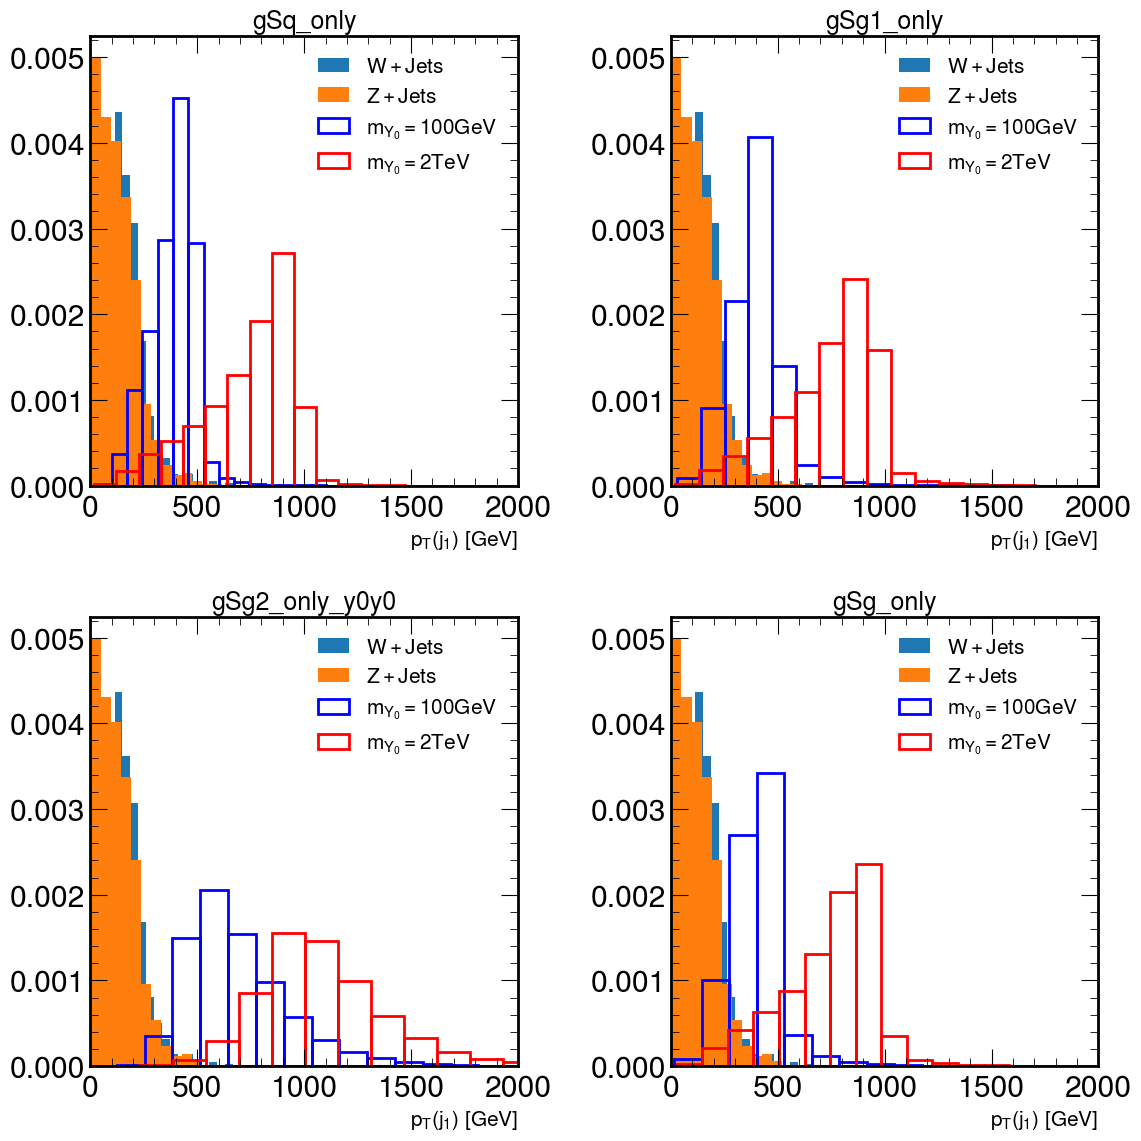

In [29]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'jet_pt1'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$p_{T}{(j_{1})}$ [GeV]",fontsize=15)
        ax[i,j].set_xlim(0,2000)


fig.tight_layout()
plt.show()


In [30]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt1', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

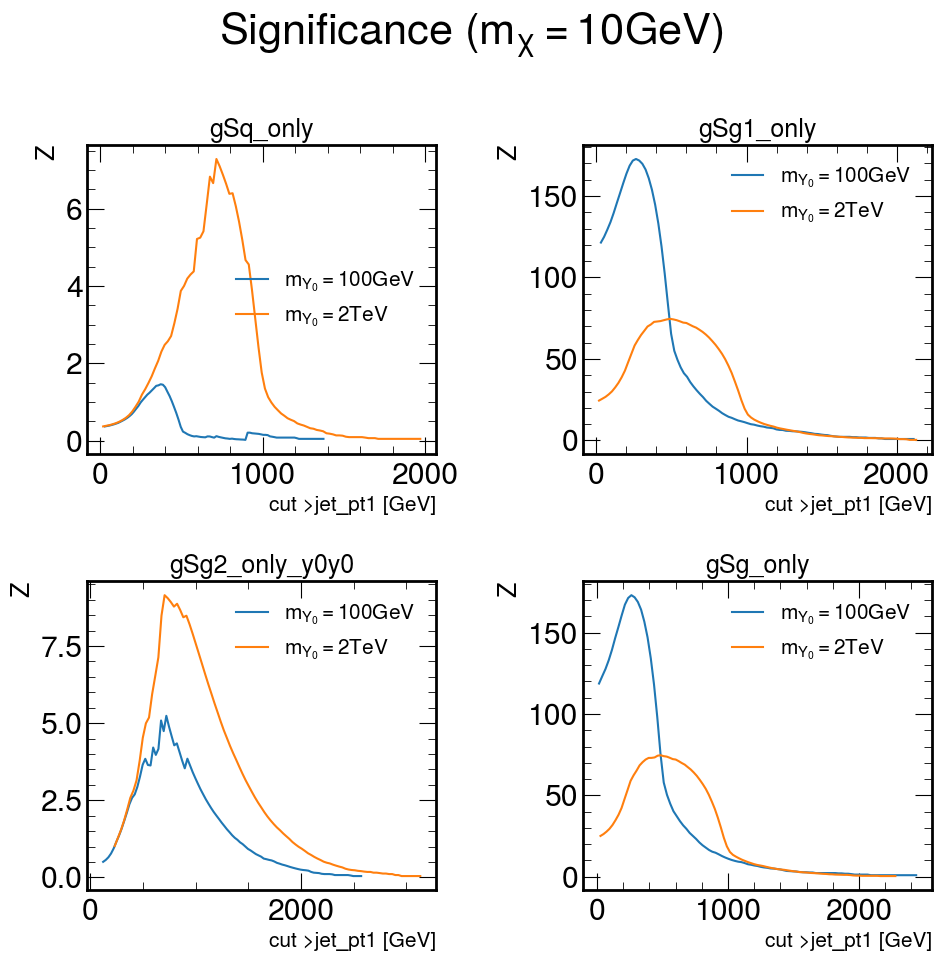

In [31]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

In [32]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt1', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']],
                                 set_lims=True, lims=(0,1000), size=500)

In [33]:
cuts = get_cuts(cases, Z, pt_values, "jet_pt1", "GeV", ["my0=100GeV", "my0=2TeV"], printResults=True)

case : gSq_only
	mass point: my0=100GeV
		max significance: 1.4636212230688925
		cut: jet_pt1 > 379.429GeV
	mass point: my0=2TeV
		max significance: 7.378220965208673
		cut: jet_pt1 > 704.887GeV
case : gSg1_only
	mass point: my0=100GeV
		max significance: 173.0733056603463
		cut: jet_pt1 > 255.9GeV
	mass point: my0=2TeV
		max significance: 74.79462720109441
		cut: jet_pt1 > 484.379GeV
case : gSg2_only_y0y0
	mass point: my0=100GeV
		max significance: 5.476301727141385
		cut: jet_pt1 > 705.122GeV
	mass point: my0=2TeV
		max significance: 9.15970380504003
		cut: jet_pt1 > 703.69GeV
case : gSg_only
	mass point: my0=100GeV
		max significance: 173.2318499430211
		cut: jet_pt1 > 256.788GeV
	mass point: my0=2TeV
		max significance: 74.73815218296379
		cut: jet_pt1 > 483.51GeV


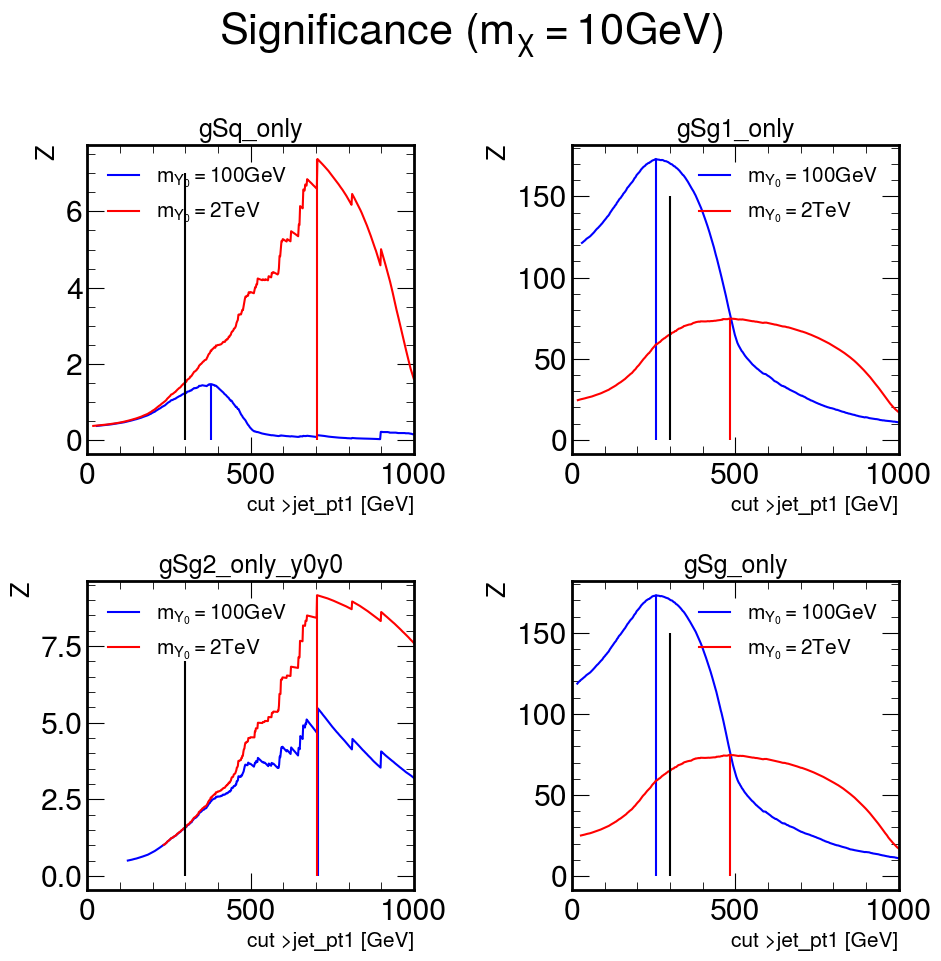

In [34]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

colors = ["b","r"]
labels = [r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"]

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i],color=colors[i], label=labels[i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i],color=colors[i], label=labels[i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i],color=colors[i], label=labels[i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i],color=colors[i], label=labels[i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=max(Z[cases[0]][i]),color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=max(Z[cases[1]][i]),color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=max(Z[cases[2]][i]),color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=max(Z[cases[3]][i]),color=colors[i])

ax[0,0].vlines(300, ymin=0, ymax=7, color='black')
ax[0,1].vlines(300, ymin=0, ymax=150, color='black')
ax[1,0].vlines(300, ymin=0, ymax=7, color='black')
ax[1,1].vlines(300, ymin=0, ymax=150, color='black')

for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1000)

fig.tight_layout()
plt.show()

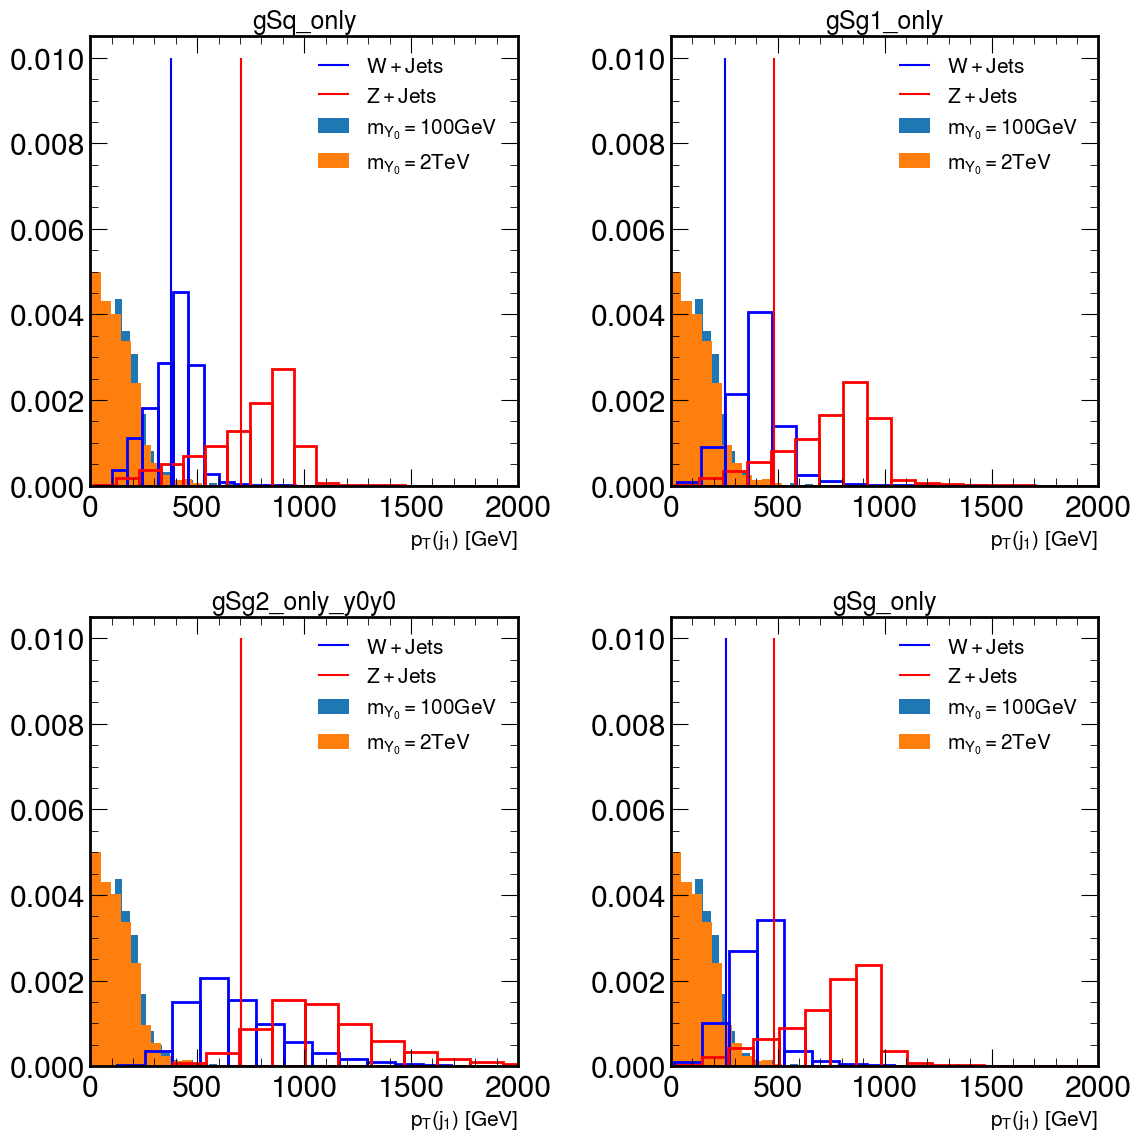

In [35]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'jet_pt1'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=0.01,color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=0.01,color=colors[i])

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$p_{T}{(j_{1})}$ [GeV]",fontsize=15)
        ax[i,j].set_xlim(0,2000)


fig.tight_layout()
plt.show()

Make cut in 300GeV

In [36]:
cut_data = {}
dataWpJ_cut = {}
dataZpJ_cut = {}
for i in cases:
    cut_data[i] = []
    dataWpJ_cut[i] = []
    dataZpJ_cut[i] = []
    for j in range(2):
        cut_data[i].append(data[i][j][data[i][j]['jet_pt0'] > cuts[i][j]].copy())
        dataWpJ_cut[i].append(data_WpJ[data_WpJ['jet_pt0'] > cuts[i][j]].copy())
        dataZpJ_cut[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > cuts[i][j]].copy())
        #cut_data2[i].append(data[i][j][data[i][j]['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        #dataWpJ_cut2[i].append(data_WpJ[data_WpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        #dataZpJ_cut2[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV

In [37]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])
print("\tCut")
print("Modelos: ",[[cut_data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets: ",[[dataWpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("ZpJets: ",[[dataZpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("\nOrden: ","gSg_only", "gSg1_only", "gSg2_only_y0y0", "gSq_only")

Número de Eventos para cada caso:
	Original
Modelos:  [[48240, 49629], [48689, 49740], [49994, 50000], [48686, 49746]]
WpJets + ZpJets:  [3081, 3710]
	Cut
Modelos:  [[39052, 38862], [47181, 46422], [33629, 49491], [47144, 46441]]
WpJets:  [[286, 14], [1317, 100], [14, 14], [1296, 101]]
ZpJets:  [[387, 13], [1657, 117], [13, 13], [1642, 120]]

Orden:  gSg_only gSg1_only gSg2_only_y0y0 gSq_only


In [38]:
for i in cases:
    for j in range(2):
        data[i][j] = data[i][j].query('jet_pt1 > 300')

data_WpJ = data_WpJ.query('jet_pt1 > 300')
data_ZpJ = data_ZpJ.query('jet_pt1 > 300')

In [39]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])

Número de Eventos para cada caso:
	Original
Modelos:  [[38366, 47345], [39434, 47758], [49564, 49993], [39438, 47779]]
WpJets + ZpJets:  [152, 165]


## Plot $p_{T}^{miss}$

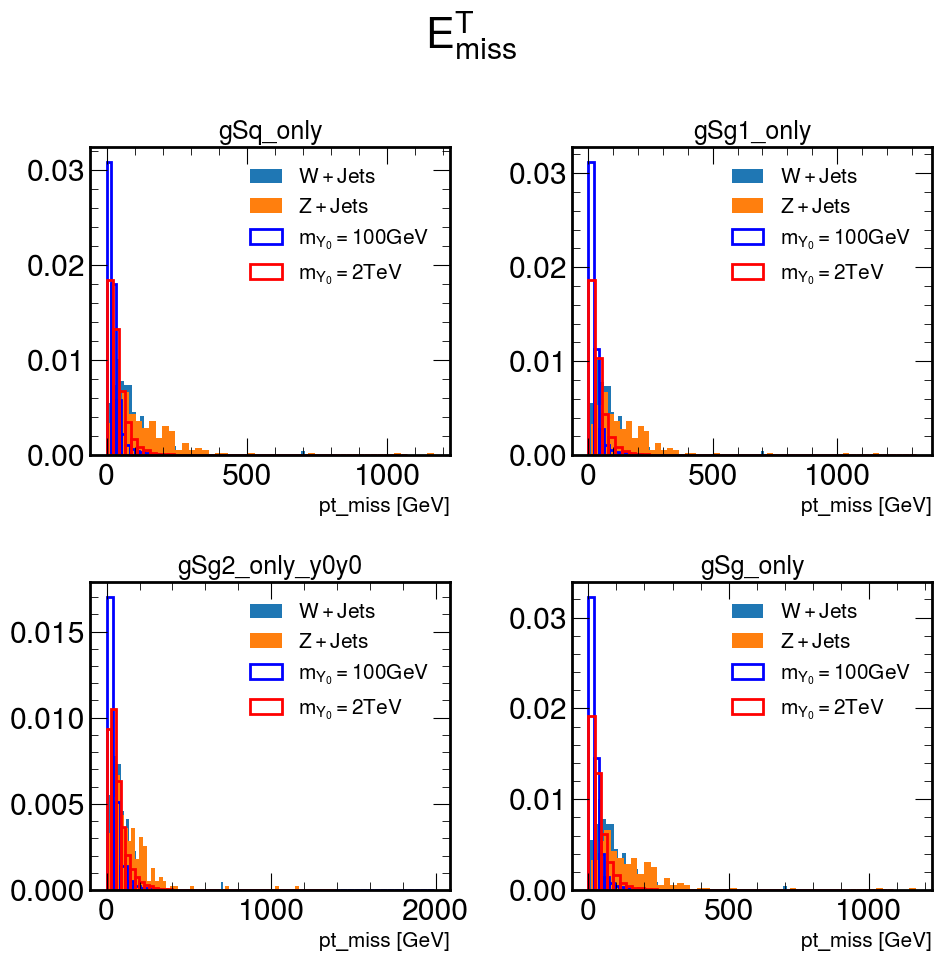

In [43]:
fig, ax = plt.subplots(2,2)
fig.suptitle(r"$E^{T}_{miss}$")

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j]['missinget_met']),max(data[i][j]['missinget_met'])))

rangos['WpJets'] = np.linspace(min(data_WpJ['missinget_met']), max(data_WpJ['missinget_met']))
rangos['ZpJets'] = np.linspace(min(data_ZpJ['missinget_met']), max(data_ZpJ['missinget_met']))

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ['missinget_met'], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ['missinget_met'], bins=rangos['ZpJets'], density=True)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i]['missinget_met'], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i]['missinget_met'], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i]['missinget_met'], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i]['missinget_met'], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("pt_miss [GeV]",fontsize=15)

fig.tight_layout()
plt.show()


#### VBF variables

$\eta(j_{1}) \cdot \eta(j_{2})$

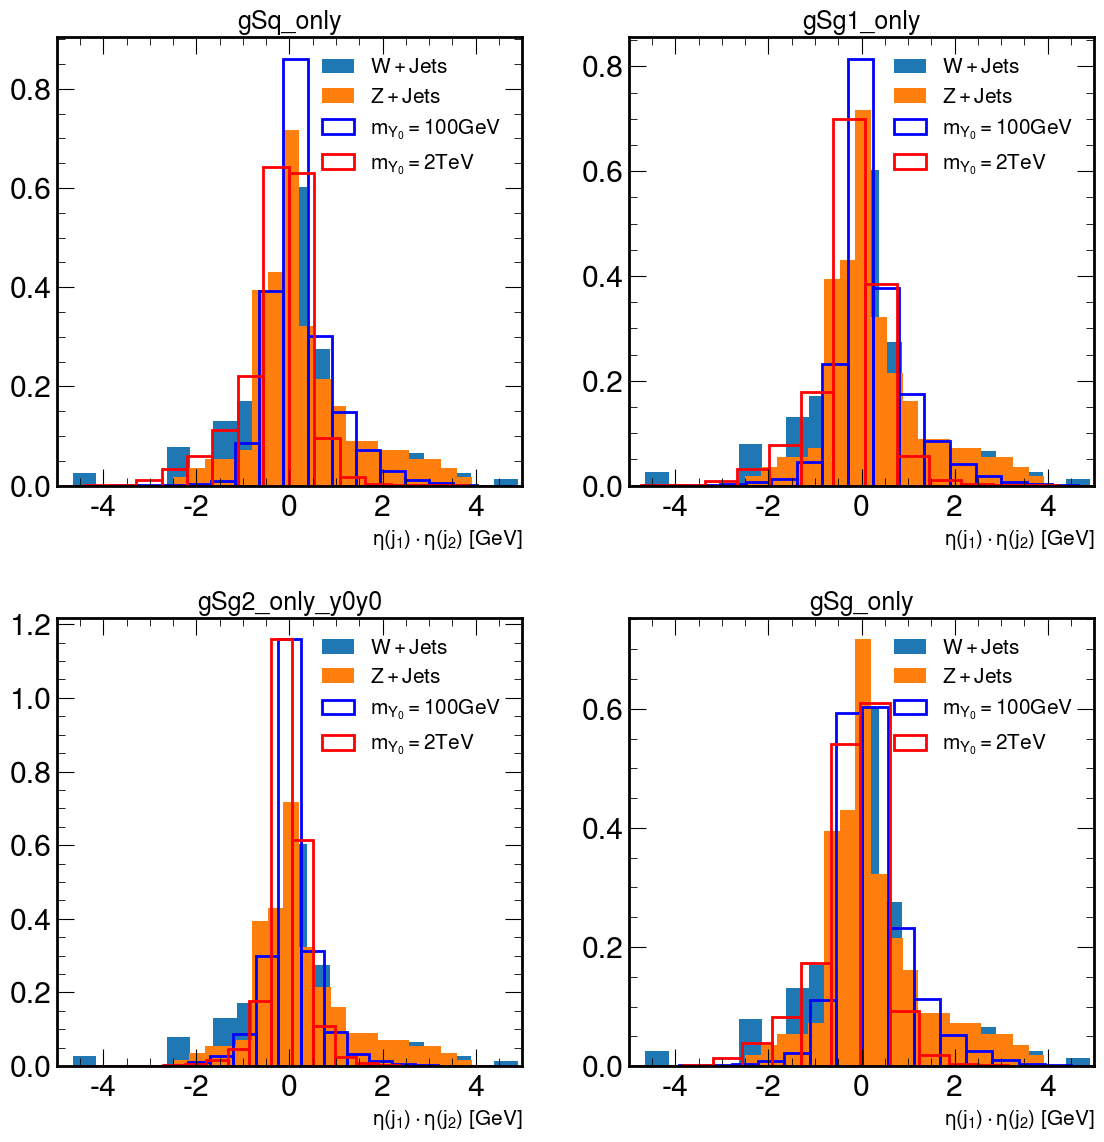

In [44]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'PseudorapidityProd'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)
        #ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV",r"$W+Jets$",r"$Z+Jets$"],fontsize=15)
        ax[i,j].set_xlabel(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$ [GeV]",fontsize=15)
        ax[i,j].set_xlim(-5,5)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$ [GeV]",fontsize=15)


fig.tight_layout()
plt.show()


In [45]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='PseudorapidityProd', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']], cond='<')

/workspaces/VBFDM_EAFIT/funcs.py:326: RuntimeWarning: invalid value encountered in scalar divide
  Z[i][j][k] = S / np.sqrt(S + B)


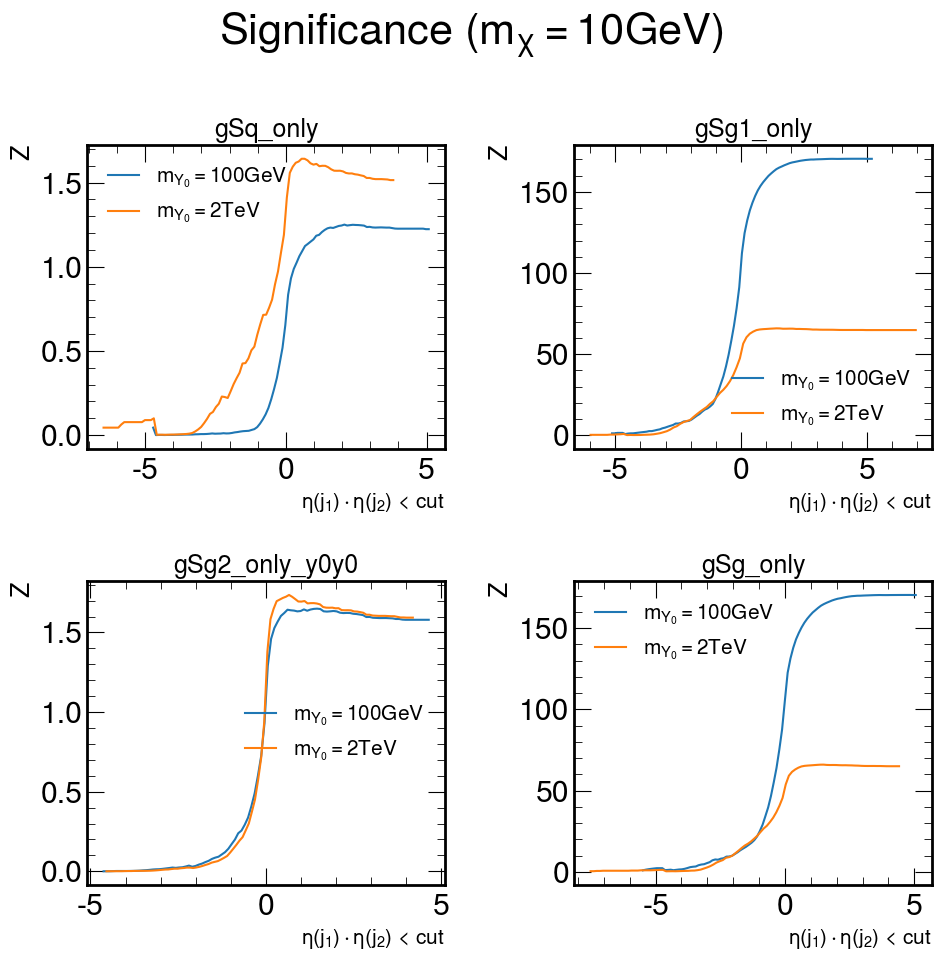

In [46]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$ < cut",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

Make cut in 0

In [47]:
cut_data = {}
dataWpJ_cut = {}
dataZpJ_cut = {}
for i in cases:
    cut_data[i] = []
    dataWpJ_cut[i] = []
    dataZpJ_cut[i] = []
    for j in range(2):
        cut_data[i].append(data[i][j][data[i][j]['PseudorapidityProd'] < 0].copy())
        dataWpJ_cut[i].append(data_WpJ[data_WpJ['PseudorapidityProd'] < 0].copy())
        dataZpJ_cut[i].append(data_ZpJ[data_ZpJ['PseudorapidityProd'] < 0].copy())
        #cut_data2[i].append(data[i][j][data[i][j]['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        #dataWpJ_cut2[i].append(data_WpJ[data_WpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        #dataZpJ_cut2[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV

In [48]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])
print("\tCut")
print("Modelos: ",[[cut_data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets: ",[[dataWpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("ZpJets: ",[[dataZpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("\nOrden: ","gSg_only", "gSg1_only", "gSg2_only_y0y0", "gSq_only")

Número de Eventos para cada caso:
	Original
Modelos:  [[38366, 47345], [39434, 47758], [49564, 49993], [39438, 47779]]
WpJets + ZpJets:  [152, 165]
	Cut
Modelos:  [[15288, 29323], [15593, 28133], [23960, 25894], [15750, 28024]]
WpJets:  [[78, 78], [78, 78], [78, 78], [78, 78]]
ZpJets:  [[72, 72], [72, 72], [72, 72], [72, 72]]

Orden:  gSg_only gSg1_only gSg2_only_y0y0 gSq_only


In [49]:
for i in cases:
    for j in range(2):
        data[i][j] = data[i][j].query('PseudorapidityProd < 0')

data_WpJ = data_WpJ.query('PseudorapidityProd < 0')
data_ZpJ = data_ZpJ.query('PseudorapidityProd < 0')

In [50]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])

Número de Eventos para cada caso:
	Original
Modelos:  [[15288, 29323], [15593, 28133], [23960, 25894], [15750, 28024]]
WpJets + ZpJets:  [78, 72]


### $\Delta\phi_{jj}$

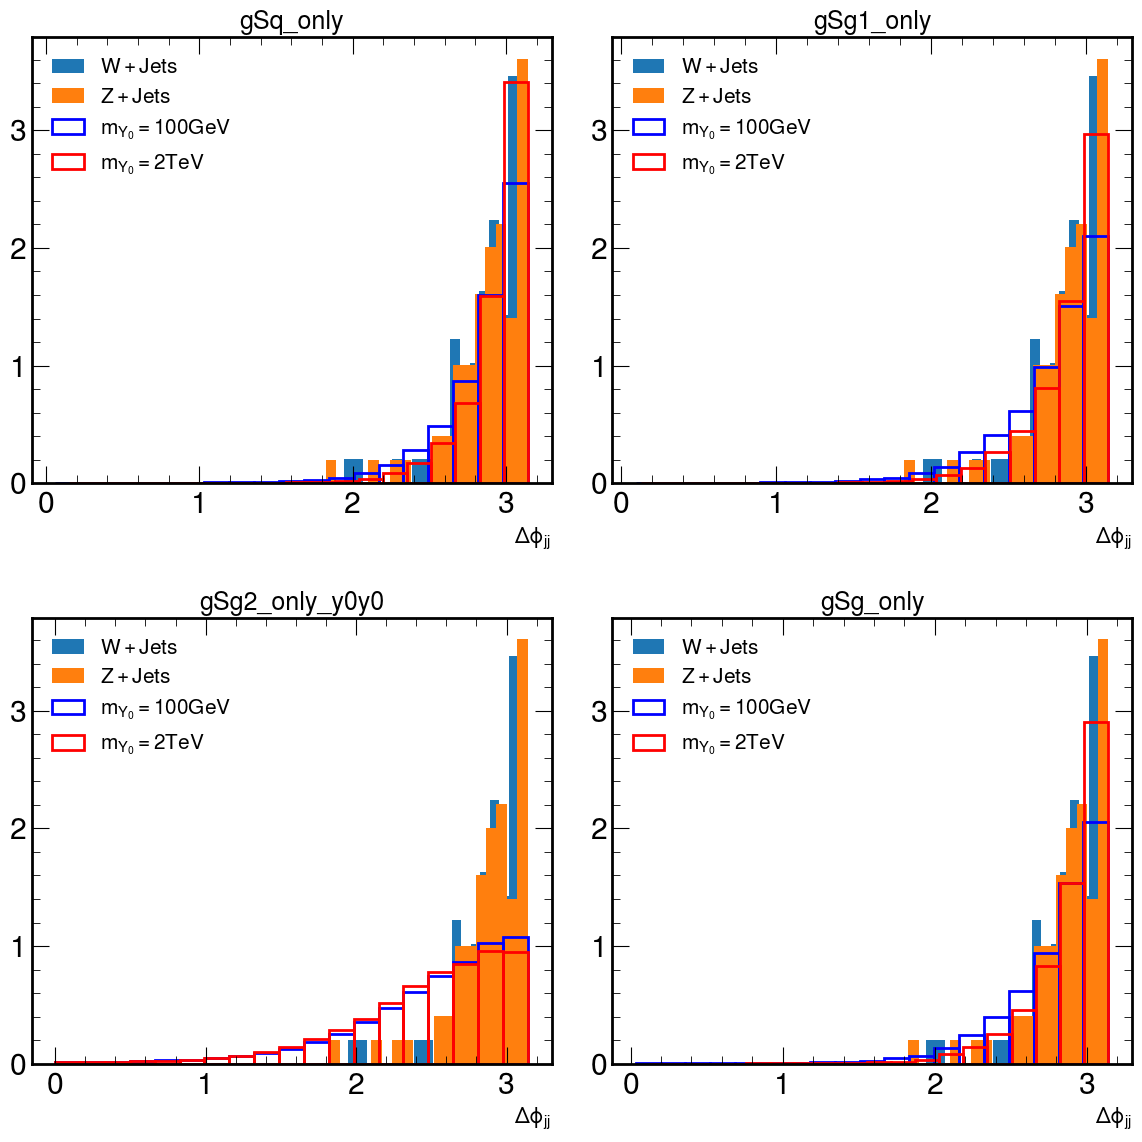

In [54]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'Azim_diff'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)
        #ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV",r"$W+Jets$",r"$Z+Jets$"],fontsize=15)
        
        #ax[i,j].set_xlim(-5,5)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\Delta\phi_{jj}$",fontsize=15)


fig.tight_layout()
plt.show()


In [55]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='Azim_diff', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/workspaces/VBFDM_EAFIT/funcs.py:326: RuntimeWarning: invalid value encountered in scalar divide
  Z[i][j][k] = S / np.sqrt(S + B)


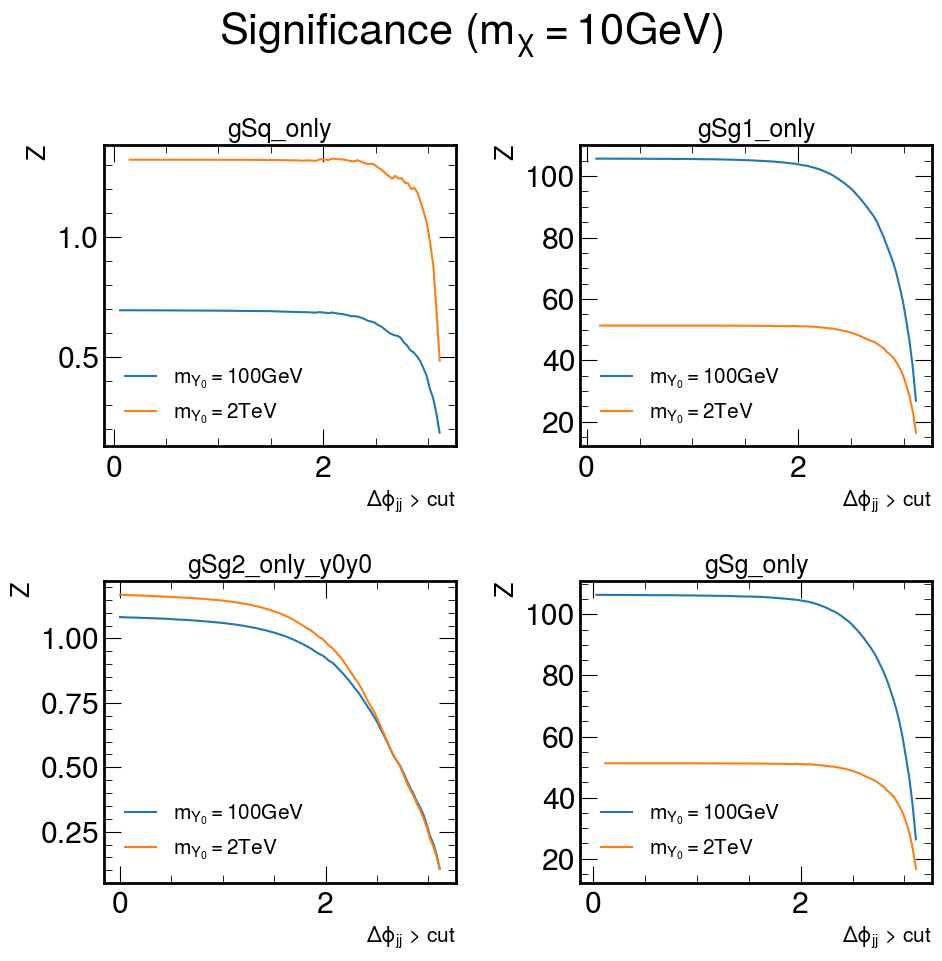

In [56]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\Delta\phi_{jj}$ > cut",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

### $m_{jj}$

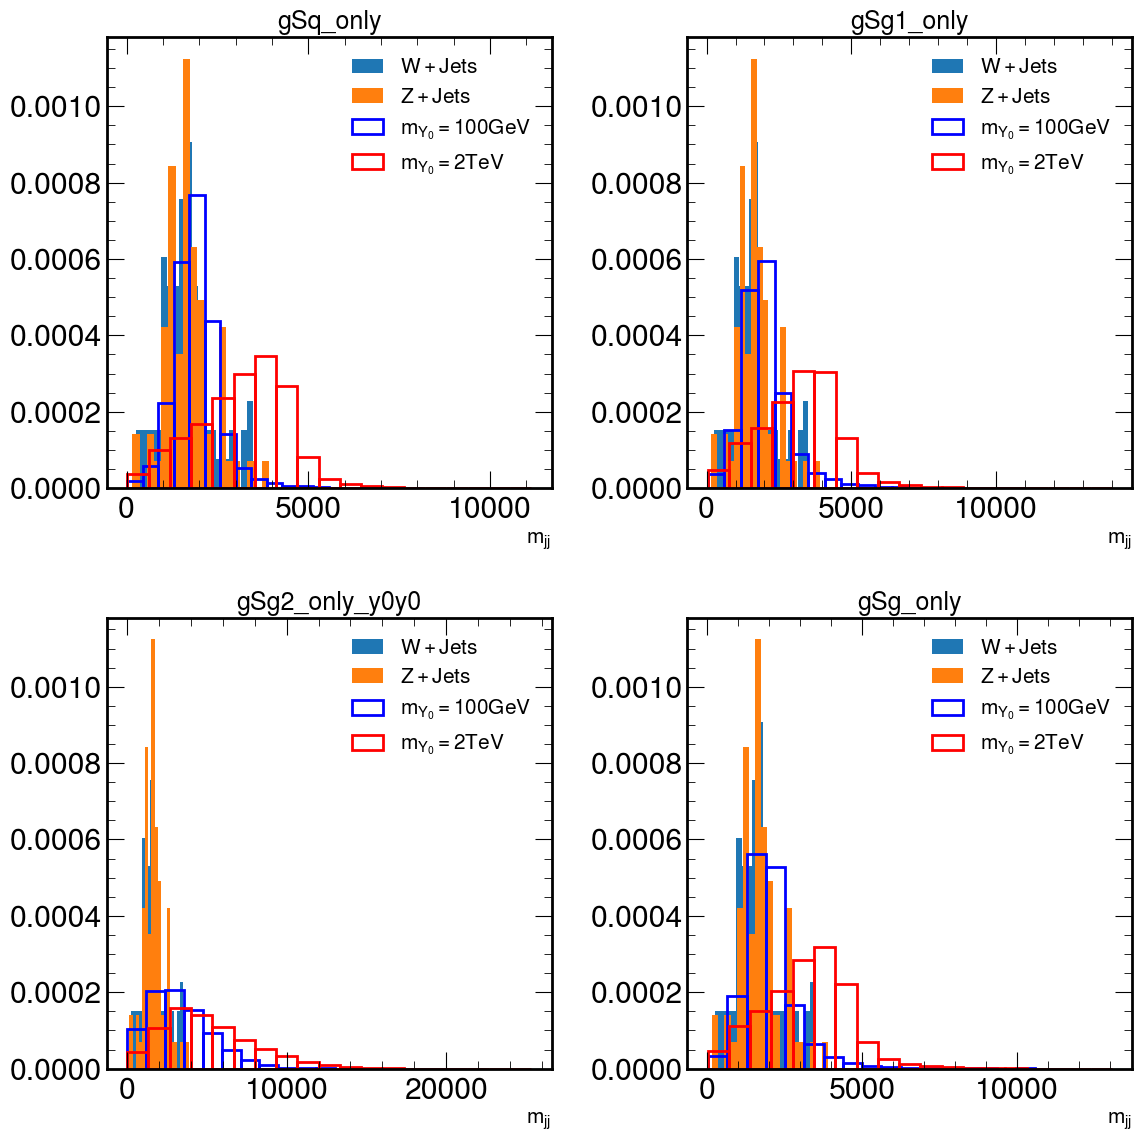

In [57]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'Inv_Mass'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)
        #ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV",r"$W+Jets$",r"$Z+Jets$"],fontsize=15)
        
        #ax[i,j].set_xlim(-5,5)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$m_{jj}$",fontsize=15)


fig.tight_layout()
plt.show()


In [58]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='Inv_Mass', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

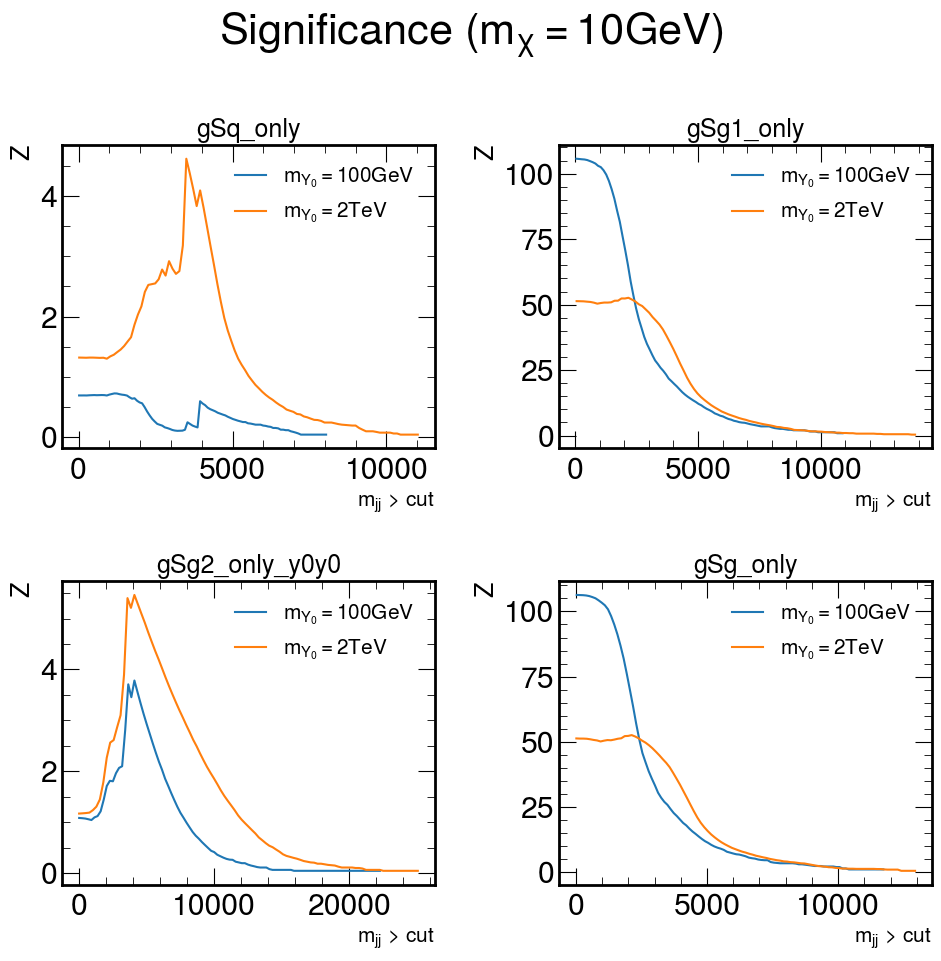

In [60]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$m_{jj}$ > cut",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

### $\Delta \eta_{jj}$

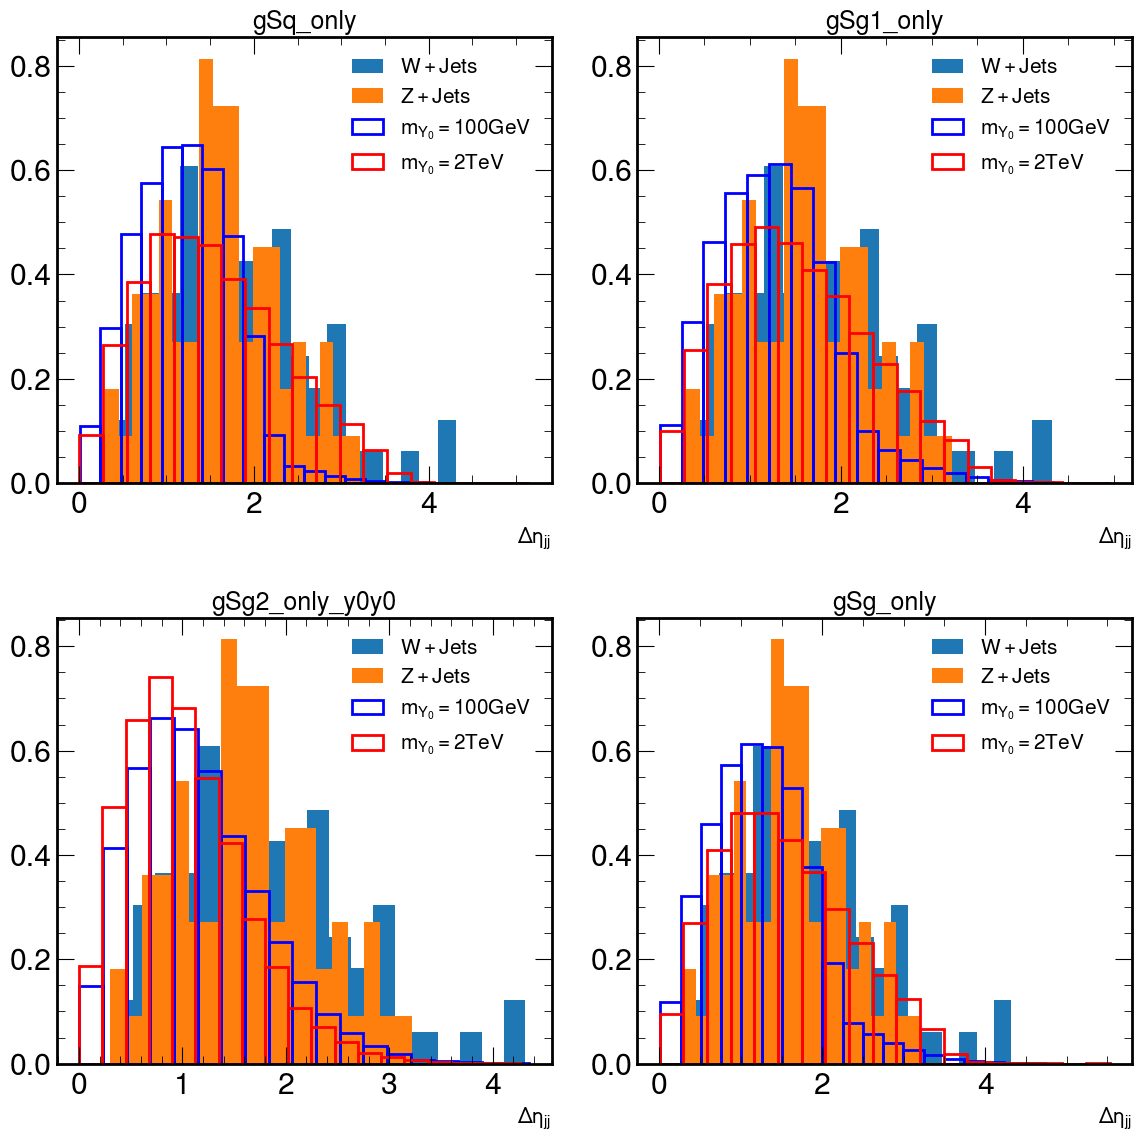

In [61]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'Pseudorapidity'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)
        #ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV",r"$W+Jets$",r"$Z+Jets$"],fontsize=15)
        
        #ax[i,j].set_xlim(-5,5)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\Delta\eta_{jj}$",fontsize=15)


fig.tight_layout()
plt.show()

In [62]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='Pseudorapidity', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

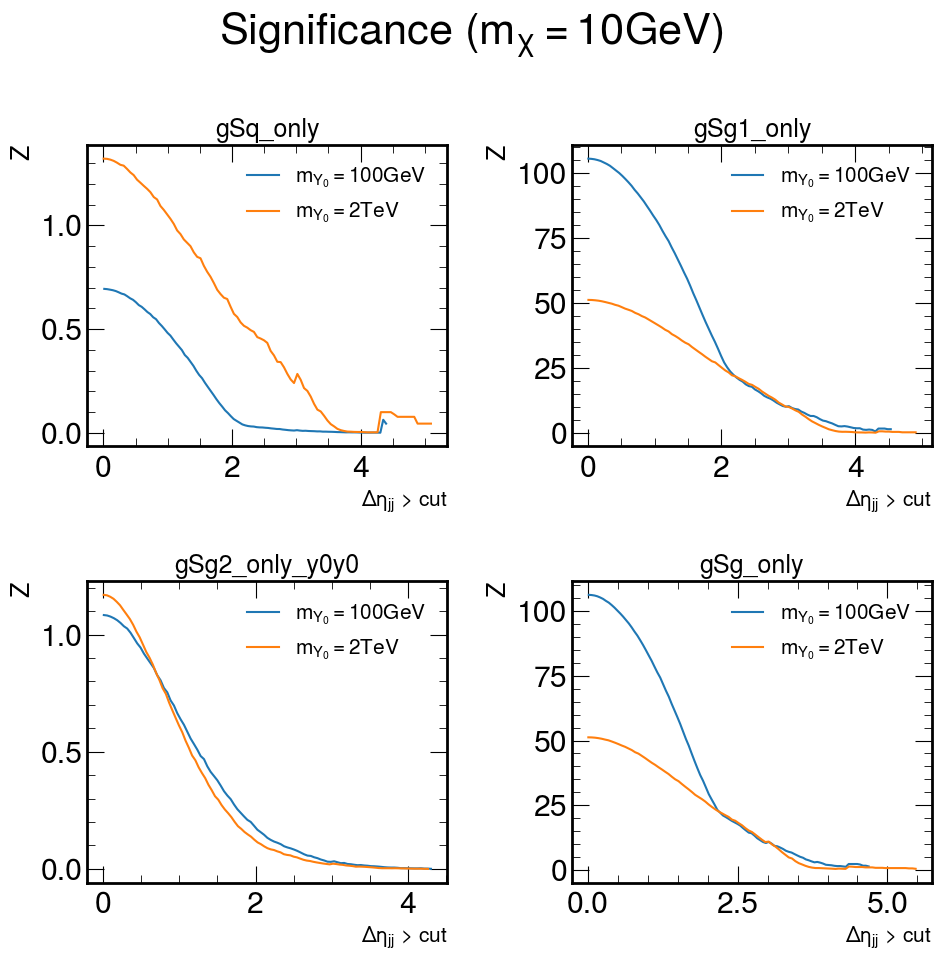

In [63]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\Delta\eta_{jj}$ > cut",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()